# Scenario 00: Token Sweep (`cold` vs `cache_hit`)

This notebook runs a token-length sweep.

For each token target, it runs exactly:
- 1 `cold` request
- 1 `cache_hit` request

An unmeasured warmup request is executed first to reduce one-time startup distortion.
The measured `cold` and `cache_hit` use the same question for fair comparison.

The output charts show TTFT and latency versus token length.

## Runtime Contract

Required from `.env`:
- `OPENAI_BASE_URL`
- `OPENAI_API_KEY`
- `TENSORMESH_USER_ID`
- `OPENAI_MODEL`

Optional tuning:
- `SCENARIO_TOKEN_TARGETS` (default `4000,8000,...,40000`)
- `MANUAL_SECTIONS` (default `1200`)
- `MAX_TOKENS` (default `64`)
- `TEMPERATURE` (default `0.0`)
- `TTFT_MIN_REDUCTION_FRACTION` (default `0.10`)
- `SCENARIO_ISOLATION_ID` (default auto-generated)

In [1]:
from __future__ import annotations

from hashlib import sha256
from pathlib import Path
import os
import random
import sys
from uuid import uuid4


def resolve_scenario_dir() -> Path:
    cwd = Path.cwd()
    candidates = [cwd, cwd / 'scenarios/00_long_document_chat']
    for candidate in candidates:
        if (candidate / 'src').exists() and (
                candidate / 'scenario_00_long_document_chat.ipynb').exists():
            return candidate
    for parent in [cwd, *cwd.parents]:
        candidate = parent / 'scenarios/00_long_document_chat'
        if (candidate / 'src').exists() and (
                candidate / 'scenario_00_long_document_chat.ipynb').exists():
            return candidate
    raise RuntimeError(
        'Could not locate scenarios/00_long_document_chat directory.')


SCENARIO_DIR = resolve_scenario_dir()
if str(SCENARIO_DIR) not in sys.path:
    sys.path.insert(0, str(SCENARIO_DIR))

from src.config import Settings, create_openai_client
from src.utils.metrics import stream_chat_completion
from src.utils.reporting import plot_token_sweep, print_token_sweep_table, summarize_assertions

In [2]:
settings = Settings.from_env(load_env_file=True)
client = create_openai_client(settings)
ttft_min_reduction_fraction = float(
    os.environ.get('TTFT_MIN_REDUCTION_FRACTION', '0.10'))
scenario_isolation_id = os.environ.get('SCENARIO_ISOLATION_ID',
                                       uuid4().hex[:12])
token_targets = sorted(settings.token_targets)

print('Configuration')
print(f'  OPENAI_BASE_URL              : {settings.openai_base_url}')
print(f'  OPENAI_MODEL                 : {settings.openai_model}')
print(f'  SCENARIO_TOKEN_TARGETS       : {token_targets}')
print(f'  MANUAL_SECTIONS              : {settings.manual_sections}')
print(f'  MAX_TOKENS                   : {settings.max_tokens}')
print(f'  TEMPERATURE                  : {settings.temperature}')
print(f'  TTFT_MIN_REDUCTION_FRACTION  : {ttft_min_reduction_fraction:.2%}')
print(f'  SCENARIO_ISOLATION_ID        : {scenario_isolation_id}')

Configuration
  OPENAI_BASE_URL              : https://external.nebius.tensormesh.ai/v1
  OPENAI_MODEL                 : openai/gpt-oss-20b
  SCENARIO_TOKEN_TARGETS       : [4000, 8000, 12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000]
  MANUAL_SECTIONS              : 1200
  MAX_TOKENS                   : 64
  TEMPERATURE                  : 0.0
  TTFT_MIN_REDUCTION_FRACTION  : 10.00%
  SCENARIO_ISOLATION_ID        : d2573d8971e0


In [3]:
def approx_tokens(text: str) -> int:
    return len(text) // 4


def run_hash(seed: int, idx: int, target_tokens: int,
             isolation_id: str) -> str:
    raw = f'{seed}:{idx}:{target_tokens}:{isolation_id}'.encode('utf-8')
    return sha256(raw).hexdigest()[:16]


def section_text(seed: int, section_idx: int, run_tag: str) -> str:
    rng = random.Random(seed + section_idx)
    categories = [
        'incident triage',
        'retention policy',
        'access control',
        'billing operations',
        'security response',
        'audit workflow',
    ]
    category = categories[section_idx % len(categories)]
    level = rng.choice(['P0', 'P1', 'P2', 'P3'])
    retention_days = 30 + (section_idx % 7) * 15
    return '\n'.join([
        f'## Section {section_idx:04d}: {category.title()}',
        f'- Run marker: {run_tag}',
        f'- Severity level: {level}',
        f'- Standard retention: {retention_days} days',
        '- Escalation rule: notify the duty manager within 10 minutes for customer-impacting incidents.',
        '- Exception: legal hold requests override standard retention windows.',
        '- Validation: include ticket id, ownership team, and policy reference in every handoff.',
        '',
    ])


def build_document_for_target(seed: int, target_tokens: int, run_tag: str,
                              max_sections: int) -> tuple[str, int, int]:
    lines = [
        '# Enterprise Operations Handbook',
        f'Run marker: {run_tag}',
        'This handbook is used by support agents during customer conversations.',
        '',
    ]
    used_sections = 0
    for section_idx in range(1, max_sections + 1):
        lines.append(section_text(seed, section_idx, run_tag))
        used_sections = section_idx
        document = '\n'.join(lines)
        if approx_tokens(document) >= target_tokens:
            return document, approx_tokens(document), used_sections
    raise RuntimeError(
        f'Could not reach token target {target_tokens} with MANUAL_SECTIONS={max_sections}.'
    )

In [4]:
def build_user_prompt(*, manual_prefix: str, question: str) -> str:
    return (
        '### Reference Document\n'
        f'{manual_prefix}\n\n'
        '### Assistant Instructions\n'
        'Answer based only on the reference document. If uncertain, say what is missing.\n\n'
        '### User Question\n'
        f'{question}')


def run_single_request(manual_prefix: str, question: str) -> dict:
    prompt = build_user_prompt(manual_prefix=manual_prefix, question=question)
    messages = [
        {
            'role': 'system',
            'content': 'You are a precise operations support assistant.'
        },
        {
            'role': 'user',
            'content': prompt
        },
    ]
    stream_result = stream_chat_completion(
        client,
        model=settings.openai_model,
        messages=messages,
        temperature=settings.temperature,
        max_tokens=settings.max_tokens,
    )
    usage = stream_result.usage or {}
    return {
        'ttft_ms': stream_result.ttft_ms,
        'latency_ms': stream_result.latency_ms,
        'prompt_tokens': usage.get('prompt_tokens'),
        'completion_tokens': usage.get('completion_tokens'),
        'total_tokens': usage.get('total_tokens'),
    }

In [5]:
QUESTION_TEXT = ('List exactly three escalation rules from the document. '
                 'Use short bullet points and no extra commentary.')

# Unmeasured warmup to avoid startup/JIT skew in first measured point.
warmup_target = token_targets[0]
warmup_tag = run_hash(settings.manual_seed, 0, warmup_target,
                      scenario_isolation_id)
warmup_doc, warmup_doc_tokens, warmup_sections = build_document_for_target(
    settings.manual_seed,
    warmup_target,
    warmup_tag,
    settings.manual_sections,
)
warmup_prefix = f'SESSION_PREFIX_HASH={warmup_tag}\n{warmup_doc}'
print(
    f'Warmup: target={warmup_target}, actual~{warmup_doc_tokens}, sections={warmup_sections}, hash={warmup_tag}'
)
_ = run_single_request(warmup_prefix, QUESTION_TEXT)
print('Warmup complete (not included in results).')

points = []
for idx, target_tokens in enumerate(token_targets, start=1):
    run_tag = run_hash(settings.manual_seed, idx, target_tokens,
                       scenario_isolation_id)
    document, doc_tokens, used_sections = build_document_for_target(
        settings.manual_seed,
        target_tokens,
        run_tag,
        settings.manual_sections,
    )
    manual_prefix = f'SESSION_PREFIX_HASH={run_tag}\n{document}'

    print(
        f'\nTarget {idx}/{len(token_targets)}: {target_tokens} tokens (actual~{doc_tokens}, sections={used_sections}, hash={run_tag})'
    )

    cold = run_single_request(manual_prefix, QUESTION_TEXT)
    hit = run_single_request(manual_prefix, QUESTION_TEXT)

    if cold['ttft_ms'] is None or hit['ttft_ms'] is None:
        raise RuntimeError(f'Missing TTFT for target {target_tokens}.')
    if cold['latency_ms'] is None or hit['latency_ms'] is None:
        raise RuntimeError(f'Missing latency for target {target_tokens}.')

    token_axis = cold['prompt_tokens'] or doc_tokens
    ttft_reduction = 1.0 - (float(hit['ttft_ms']) / float(cold['ttft_ms']))
    latency_reduction = 1.0 - (float(hit['latency_ms']) /
                               float(cold['latency_ms']))

    point = {
        'index': idx,
        'token_target': target_tokens,
        'token_axis': int(token_axis),
        'run_hash': run_tag,
        'ttft_cold_ms': float(cold['ttft_ms']),
        'ttft_cache_hit_ms': float(hit['ttft_ms']),
        'latency_cold_ms': float(cold['latency_ms']),
        'latency_cache_hit_ms': float(hit['latency_ms']),
        'ttft_reduction_fraction': ttft_reduction,
        'latency_reduction_fraction': latency_reduction,
        'prompt_tokens_cold': cold['prompt_tokens'],
        'prompt_tokens_cache_hit': hit['prompt_tokens'],
    }
    points.append(point)

    print(
        f"  cold ttft={point['ttft_cold_ms']:.1f} ms, cache_hit ttft={point['ttft_cache_hit_ms']:.1f} ms, reduction={point['ttft_reduction_fraction']:.2%}"
    )

Warmup: target=4000, actual~4010, sections=43, hash=631271618c3d370b


Warmup complete (not included in results).

Target 1/10: 4000 tokens (actual~4010, sections=43, hash=ab041353caf7d620)


  cold ttft=2040.0 ms, cache_hit ttft=1579.9 ms, reduction=22.55%

Target 2/10: 8000 tokens (actual~8079, sections=87, hash=1e2e8a0bba1a88e6)


  cold ttft=1431.8 ms, cache_hit ttft=2705.6 ms, reduction=-88.97%

Target 3/10: 12000 tokens (actual~12057, sections=130, hash=2640352cc9bdb2c9)


  cold ttft=2691.0 ms, cache_hit ttft=1501.1 ms, reduction=44.22%

Target 4/10: 16000 tokens (actual~16033, sections=173, hash=2ee31c781304a4a0)


  cold ttft=2303.4 ms, cache_hit ttft=1463.7 ms, reduction=36.45%

Target 5/10: 20000 tokens (actual~20010, sections=216, hash=63cda9ea19193af5)


  cold ttft=8022.5 ms, cache_hit ttft=1371.2 ms, reduction=82.91%

Target 6/10: 24000 tokens (actual~24079, sections=260, hash=e61b709e0623a24f)


  cold ttft=2402.3 ms, cache_hit ttft=1774.8 ms, reduction=26.12%

Target 7/10: 28000 tokens (actual~28057, sections=303, hash=69ff5d54d872029a)


  cold ttft=2898.2 ms, cache_hit ttft=1863.4 ms, reduction=35.70%

Target 8/10: 32000 tokens (actual~32034, sections=346, hash=579cc7372184b84d)


  cold ttft=2775.4 ms, cache_hit ttft=1678.0 ms, reduction=39.54%

Target 9/10: 36000 tokens (actual~36011, sections=389, hash=c75182275e9ccba8)


  cold ttft=2369.0 ms, cache_hit ttft=1594.5 ms, reduction=32.69%

Target 10/10: 40000 tokens (actual~40080, sections=433, hash=c0b4d8644e489df1)


  cold ttft=3137.2 ms, cache_hit ttft=1757.3 ms, reduction=43.98%


In [6]:
print_token_sweep_table(points)

assertions = summarize_assertions(
    points,
    min_reduction_fraction=ttft_min_reduction_fraction,
)
print('\nAssertion result')
print(f"  median cold TTFT     : {assertions['median_cold_ttft_ms']}")
print(f"  median cache_hit TTFT: {assertions['median_cache_hit_ttft_ms']}")
if assertions['ttft_reduction_fraction'] is not None:
    print(
        f"  reduction            : {assertions['ttft_reduction_fraction']:.2%}"
    )
print(f"  minimum required     : {assertions['min_reduction_fraction']:.2%}")
print(
    f"  points passed        : {assertions['points_passed']}/{assertions['points_total']}"
)
print(f"  pass                 : {assertions['passed']}")

Token sweep results
target_tok  axis_tok   ttft_cold  ttft_hit  lat_cold  lat_hit  ttft_delta%  lat_delta%
      4000      3836     2040.0    1579.9    3056.2   2138.6       22.55      30.02
      8000      8301     1431.8    2705.6    2029.7   3048.1      -88.97     -50.17
     12000     11786     2691.0    1501.1    3110.1   1783.6       44.22      42.65
     16000     15627     2303.4    1463.7    2590.5   3727.1       36.45     -43.88
     20000     19251     8022.5    1371.2    8319.6   1709.2       82.91      79.46
     24000     23138     2402.3    1774.8    2696.1   2046.4       26.12      24.10
     28000     26936     2898.2    1863.4    3223.9   2436.4       35.70      24.43
     32000     30386     2775.4    1678.0    3074.4   1958.2       39.54      36.31
     36000     34141     2369.0    1594.5    2637.5   1858.7       32.69      29.53
     40000     38855     3137.2    1757.3    3395.8   2071.7       43.98      38.99

Assertion result
  median cold TTFT     : 2546.69427

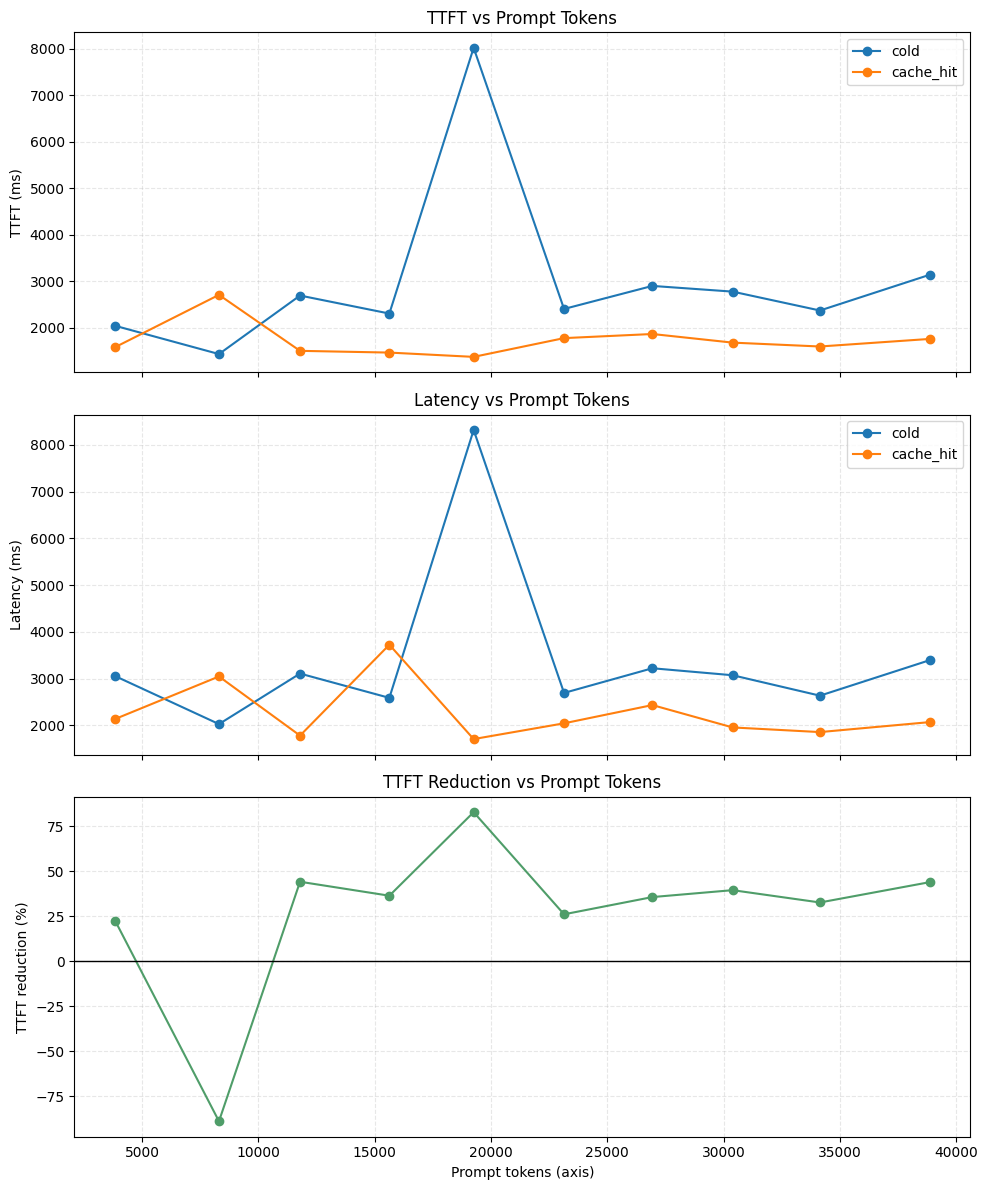

In [7]:
plot_token_sweep(points)

## Notes

- Each token target is executed once (`cold` then `cache_hit`).
- Isolation is enforced with a unique `SESSION_PREFIX_HASH` and run marker across the entire document.
- X-axis uses `prompt_tokens` from the `cold` request when available, otherwise document token estimate.